In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

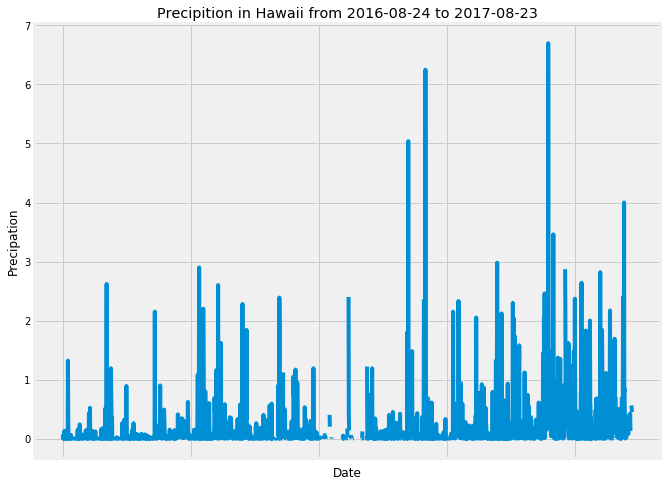

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

from datetime import datetime
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Calculate the date 1 year ago from the last data point in the database

last_year

# Perform a query to retrieve the data and precipitation scores

last_twelve = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year)

# Save the query results as a Pandas DataFrame and set the index to the date column

last_twelve_precip = pd.read_sql_query(last_twelve.statement, engine, index_col = 'date')

# Sort the dataframe by date

last_twelve_precip.head()

# Use Pandas Plotting with Matplotlib to plot the data

last_twelve_precip.plot(figsize = (10,8), rot = 45, use_index = True, legend=False)
plt.ylabel('Precipation')
plt.xlabel('Date')
plt.title("Precipition in Hawaii from %s to %s" % (last_twelve_precip.index.min(),last_twelve_precip.index.max()))
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

last_twelve_precip.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?

locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activity = session.query(Station.station, func.count(Measurement.tobs)).filter(Station.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?



[(54.0, 85.0, 71.66378066378067)]

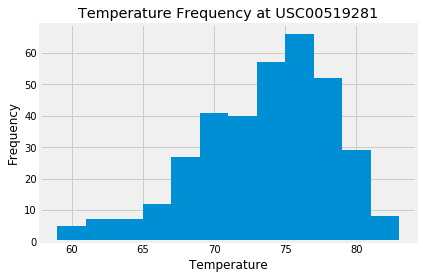

In [33]:
# Choose the station with the highest number of temperature observations.

max_activity = activity[0][0]
max_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == max_activity).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp = pd.DataFrame(max_temp)
plt.hist(temp['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at " + max_activity)
plt.show()

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps2(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps2('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_values = session.query(Measurement.tobs).filter(Measurement.date >= calc_temps2[0], Measurement.date <= new_dates[1]).all()
temp_values_list = [x for (x,) in temp_values]
avg_temp = np.mean(temp_values_list)
max_temp = max(temp_values_list)
min_temp = min(temp_values_list)

plt.figure(figsize=(2,5))
plt.title("Trip Average Temp")
plt.ylabel("Temperature (F)")
plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
plt.show()

TypeError: 'function' object is not subscriptable

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
